## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Бухтеев Кирилл Юрьевич

In [14]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [15]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [16]:
images_train, labels_train = next(iter(train_loader))

In [17]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

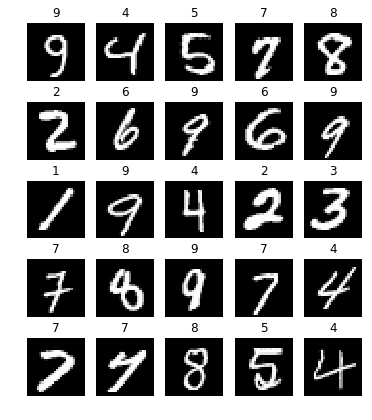

In [18]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [19]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [20]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [21]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

init_f = xavier_init_uni
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.037490725517273
forward 1.133588194847107
forward 1.1199121475219727
forward 1.1197775602340698
forward 1.1102498769760132
forward 1.1371946334838867
forward 1.127088189125061
forward 1.1229040622711182
forward 1.1041702032089233
forward 1.111655592918396
backward 0.049888771027326584
backward 0.022289056330919266
backward 0.022281063720583916
backward 0.02158447355031967
backward 0.021989881992340088
backward 0.021880023181438446
backward 0.021951619535684586
backward 0.021553345024585724
backward 0.023002469912171364
backward 0.02381649985909462


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [22]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [23]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.610/0.314	Accuracy: 0.843/0.926


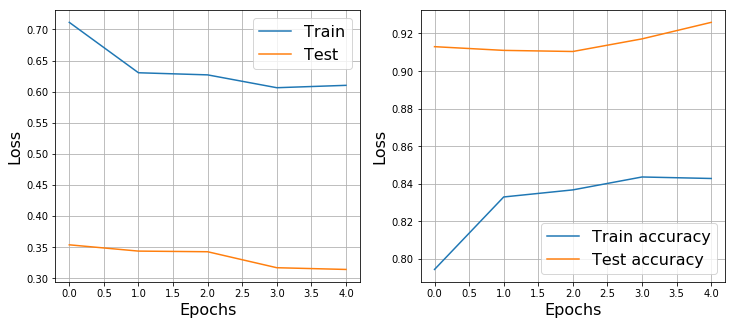

([0.7114447362895714,
  0.6302807859139148,
  0.6268753453231315,
  0.606194396834892,
  0.6100248184793794],
 [0.3532085803490651,
  0.34309879105679597,
  0.3420626098596597,
  0.31633719000258026,
  0.31355679478449155],
 [0.7942709, 0.83288914, 0.8366649, 0.843539, 0.8427394],
 [0.91297466, 0.91099685, 0.9104035, 0.91712815, 0.9259296])

In [25]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

Epoch 4... (Train/Test) NLL: 0.671/0.312	Accuracy: 0.825/0.928


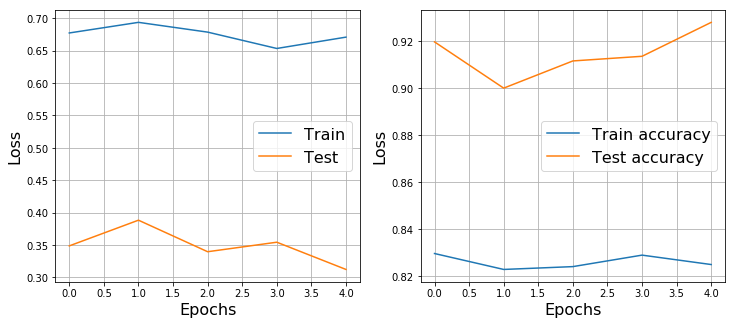

([0.6773372415794747,
  0.6937160853510981,
  0.6786435709706248,
  0.6534052133433091,
  0.6709077072296061],
 [0.348719778694684,
  0.388388184429724,
  0.33970934058292,
  0.3543884243957604,
  0.312355138361454],
 [0.82955205, 0.82277787, 0.8239827, 0.82886904, 0.8248656],
 [0.9196005, 0.8999209, 0.9114913, 0.91346914, 0.9279074])

In [26]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [52]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, features, eps=1e-7):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        output = self.gamma * (x - mean) / (std + self.eps) + self.beta
        ##### YOUR CODE HERE #####
        return output
 

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 4... (Train/Test) NLL: 0.065/0.114	Accuracy: 0.980/0.971


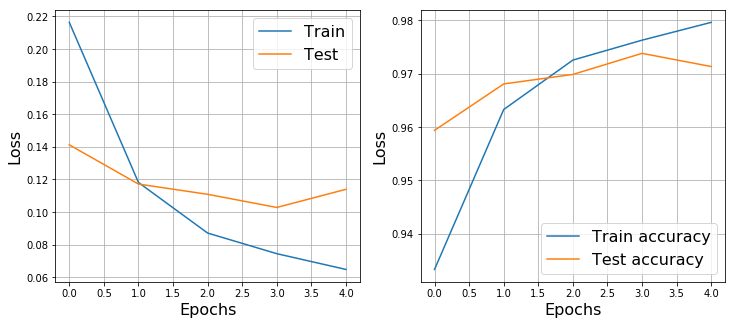

([0.21629536287712137,
  0.11808332300850197,
  0.08707590018913372,
  0.07442292110668793,
  0.06475466290470967],
 [0.14117545278483554,
  0.11711549348657645,
  0.11084035677906079,
  0.10277992828242198,
  0.11390306541248213],
 [0.93327445, 0.96325845, 0.9725313, 0.9762627, 0.9796053],
 [0.95935524, 0.96805775, 0.96983784, 0.9737935, 0.9713212])

In [41]:
##### YOUR CODE HERE #####\

net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
   
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.ReLU())
    net.append(nn.BatchNorm1d(out_dim))
    
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

Epoch 4... (Train/Test) NLL: 0.058/0.073	Accuracy: 0.981/0.978


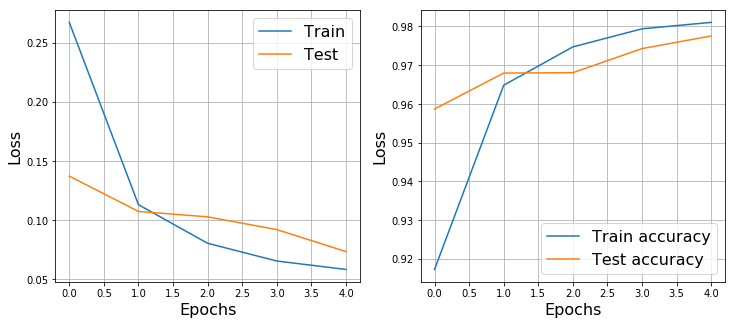

([0.26713391090395733,
  0.11288690330512298,
  0.08022113153532243,
  0.06523558380765351,
  0.05810020216502376],
 [0.13703836536600808,
  0.10717275690381663,
  0.10260584280837941,
  0.09182402682549591,
  0.07322197701027498],
 [0.9171775, 0.96481323, 0.97473013, 0.97939986, 0.98107123],
 [0.958663, 0.96795887, 0.96805775, 0.974288, 0.9775514])

In [53]:
##### YOUR CODE HERE #####\

net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.ReLU())
    net.append(LayerNormalization(out_dim))
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>


1) Нормализация дает сильный прирост точности модели, так как уменьшается дисперсия и корреляция данных, что упрощает процесс обучения

2) В данной архитектуре используется функция активации ReLu. Именно поэтому обе нормализации дают хороший результат.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: